In [34]:
import numpy as NP

"""
A module which implements the continuous wavelet transform

---------------------------------------------------------
Code released under the BSD 3-clause licence.

Copyright (c) 2012, R W Fearick, University of Cape Town
All rights reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

    * Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
    * Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.
    * Neither the name of the University of Cape Town nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
---------------------------------------------------------

Wavelet classes:
Morlet
MorletReal
MexicanHat
Paul2      : Paul order 2
Paul4      : Paul order 4
DOG1       : 1st Derivative Of Gaussian
DOG4       : 4th Derivative Of Gaussian
Haar       : Unnormalised version of continuous Haar transform
HaarW      : Normalised Haar

Usage e.g.
wavelet=Morlet(data, largestscale=2, notes=0, order=2, scaling="log")
 data:  Numeric array of data (float), with length ndata.
        Optimum length is a power of 2 (for FFT)
        Worst-case length is a prime
 largestscale:
        largest scale as inverse fraction of length
        scale = len(data)/largestscale
        smallest scale should be >= 2 for meaningful data
 notes: number of scale intervals per octave
        if notes == 0, scales are on a linear increment
 order: order of wavelet for wavelets with variable order
        [Paul, DOG, ..]
 scaling: "linear" or "log" scaling of the wavelet scale.
        Note that feature width in the scale direction
        is constant on a log scale.
        
Attributes of instance:
wavelet.cwt:       2-d array of Wavelet coefficients, (nscales,ndata)
wavelet.nscale:    Number of scale intervals
wavelet.scales:    Array of scale values
                   Note that meaning of the scale will depend on the family
wavelet.fourierwl: Factor to multiply scale by to get scale
                   of equivalent FFT
                   Using this factor, different wavelet families will
                   have comparable scales

References:
A practical guide to wavelet analysis
C Torrance and GP Compo
Bull Amer Meteor Soc Vol 79 No 1 61-78 (1998)
naming below vaguely follows this.

updates:
(24/2/07):  Fix Morlet so can get MorletReal by cutting out H
(10/04/08): Numeric -> numpy
(25/07/08): log and lin scale increment in same direction!
            swap indices in 2-d coeffiecient matrix
            explicit scaling of scale axis
"""

class Cwt:
    """
    Base class for continuous wavelet transforms
    Implements cwt via the Fourier transform
    Used by subclass which provides the method wf(self,s_omega)
    wf is the Fourier transform of the wavelet function.
    Returns an instance.
    """

    fourierwl=1.00

    def _log2(self, x):
        # utility function to return (integer) log2
        return int( NP.log(float(x))/ NP.log(2.0)+0.0001 )

    def __init__(self, data, largestscale=1, notes=0, order=2, scaling='linear'):
        """
        Continuous wavelet transform of data

        data:    data in array to transform, length must be power of 2
        notes:   number of scale intervals per octave
        largestscale: largest scale as inverse fraction of length
                 of data array
                 scale = len(data)/largestscale
                 smallest scale should be >= 2 for meaningful data
        order:   Order of wavelet basis function for some families
        scaling: Linear or log
        """
        ndata = len(data)
        self.order=order
        self.scale=largestscale
        self._setscales(ndata,largestscale,notes,scaling)
        self.cwt= NP.zeros((self.nscale,ndata), NP.complex64)
        omega= NP.array(range(0,ndata/2)+range(-ndata/2,0))*(2.0*NP.pi/ndata)
        datahat=NP.fft.fft(data)
        self.fftdata=datahat
        #self.psihat0=self.wf(omega*self.scales[3*self.nscale/4])
        # loop over scales and compute wvelet coeffiecients at each scale
        # using the fft to do the convolution
        for scaleindex in range(self.nscale):
            currentscale=self.scales[scaleindex]
            self.currentscale=currentscale  # for internal use
            s_omega = omega*currentscale
            psihat=self.wf(s_omega)
            psihat = psihat *  NP.sqrt(2.0*NP.pi*currentscale)
            convhat = psihat * datahat
            W    = NP.fft.ifft(convhat)
            self.cwt[scaleindex,0:ndata] = W 
        return
    
    def _setscales(self,ndata,largestscale,notes,scaling):
        """
        if notes non-zero, returns a log scale based on notes per ocave
        else a linear scale
        (25/07/08): fix notes!=0 case so smallest scale at [0]
        """
        if scaling=="log":
            if notes<=0: notes=1 
            # adjust nscale so smallest scale is 2 
            noctave=self._log2( ndata/largestscale/2 )
            self.nscale=notes*noctave
            self.scales=NP.zeros(self.nscale,float)
            for j in range(self.nscale):
                self.scales[j] = ndata/(self.scale*(2.0**(float(self.nscale-1-j)/notes)))
        elif scaling=="linear":
            nmax=ndata/largestscale/2
            self.scales=NP.arange(float(2),float(nmax))
            self.nscale=len(self.scales)
        else: raise ValueError, "scaling must be linear or log"
        return
    
    def getdata(self):
        """
        returns wavelet coefficient array
        """
        return self.cwt
    def getcoefficients(self):
        return self.cwt
    def getpower(self):
        """
        returns square of wavelet coefficient array
        """
        return (self.cwt* NP.conjugate(self.cwt)).real
    def getscales(self):
        """
        returns array containing scales used in transform
        """
        return self.scales
    def getnscale(self):
        """
        return number of scales
        """
        return self.nscale

# wavelet classes    
class Morlet(Cwt):
    """
    Morlet wavelet
    """
    _omega0=5.0
    fourierwl=4* NP.pi/(_omega0+ NP.sqrt(2.0+_omega0**2))
    def wf(self, s_omega):
        H= NP.ones(len(s_omega))
        n=len(s_omega)
        for i in range(len(s_omega)):
            if s_omega[i] < 0.0: H[i]=0.0
        # !!!! note : was s_omega/8 before 17/6/03
        xhat=0.75112554*( NP.exp(-(s_omega-self._omega0)**2/2.0))*H
        return xhat

class MorletReal(Cwt):
    """
    Real Morlet wavelet
    """
    _omega0=5.0
    fourierwl=4* NP.pi/(_omega0+ NP.sqrt(2.0+_omega0**2))
    def wf(self, s_omega):
        H= NP.ones(len(s_omega))
        n=len(s_omega)
        for i in range(len(s_omega)):
            if s_omega[i] < 0.0: H[i]=0.0
        # !!!! note : was s_omega/8 before 17/6/03
        xhat=0.75112554*( NP.exp(-(s_omega-self._omega0)**2/2.0)+ NP.exp(-(s_omega+self._omega0)**2/2.0)- NP.exp(-(self._omega0)**2/2.0)+ NP.exp(-(self._omega0)**2/2.0))
        return xhat
    
class Paul4(Cwt):
    """
    Paul m=4 wavelet
    """
    fourierwl=4* NP.pi/(2.*4+1.)
    def wf(self, s_omega):
        n=len(s_omega)
        xhat= NP.zeros(n)
        xhat[0:n/2]=0.11268723*s_omega[0:n/2]**4* NP.exp(-s_omega[0:n/2])
        #return 0.11268723*s_omega**2*exp(-s_omega)*H
        return xhat

class Paul2(Cwt):
    """
    Paul m=2 wavelet
    """
    fourierwl=4* NP.pi/(2.*2+1.)
    def wf(self, s_omega):
        n=len(s_omega)
        xhat= NP.zeros(n)
        xhat[0:n/2]=1.1547005*s_omega[0:n/2]**2* NP.exp(-s_omega[0:n/2])
        #return 0.11268723*s_omega**2*exp(-s_omega)*H
        return xhat

class Paul(Cwt):
    """
    Paul order m wavelet
    """
    def wf(self, s_omega):
        Cwt.fourierwl=4* NP.pi/(2.*self.order+1.)
        m=self.order
        n=len(s_omega)
        normfactor=float(m)
        for i in range(1,2*m):
            normfactor=normfactor*i
        normfactor=2.0**m/ NP.sqrt(normfactor)
        xhat= NP.zeros(n)
        xhat[0:n/2]=normfactor*s_omega[0:n/2]**m* NP.exp(-s_omega[0:n/2])
        #return 0.11268723*s_omega**2*exp(-s_omega)*H
        return xhat

class MexicanHat(Cwt):
    """
    2nd Derivative Gaussian (mexican hat) wavelet
    """
    fourierwl=2.0* NP.pi/ NP.sqrt(2.5)
    def wf(self, s_omega):
        # should this number be 1/sqrt(3/4) (no pi)?
        #s_omega = s_omega/self.fourierwl
        #print max(s_omega)
        a=s_omega**2
        b=s_omega**2/2
        return a* NP.exp(-b)/1.1529702
        #return s_omega**2*exp(-s_omega**2/2.0)/1.1529702

class DOG4(Cwt):
    """
    4th Derivative Gaussian wavelet
    see also T&C errata for - sign
    but reconstruction seems to work best with +!
    """
    fourierwl=2.0* NP.pi/ NP.sqrt(4.5)
    def wf(self, s_omega):
        return s_omega**4* NP.exp(-s_omega**2/2.0)/3.4105319

class DOG1(Cwt):
    """
    1st Derivative Gaussian wavelet
    but reconstruction seems to work best with +!
    """
    fourierwl=2.0* NP.pi/ NP.sqrt(1.5)
    def wf(self, s_omega):
        dog1= NP.zeros(len(s_omega),np.complex64)
        dog1.imag=s_omega* NP.exp(-s_omega**2/2.0)/sqrt(pi)
        return dog1

class DOG(Cwt):
    """
    Derivative Gaussian wavelet of order m
    but reconstruction seems to work best with +!
    """
    def wf(self, s_omega):
        try:
            from scipy.special import gamma
        except ImportError:
            print "Requires scipy gamma function"
            raise ImportError
        Cwt.fourierwl=2* NP.pi/ NP.sqrt(self.order+0.5)
        m=self.order
        dog=1.0J**m*s_omega**m* NP.exp(-s_omega**2/2)/ NP.sqrt(gamma(self.order+0.5))
        return dog

class Haar(Cwt):
    """
    Continuous version of Haar wavelet
    """
    #    note: not orthogonal!
    #    note: s_omega/4 matches Lecroix scale defn.
    #          s_omega/2 matches orthogonal Haar
    # 2/8/05 constants adjusted to match artem eim

    fourierwl=1.0#1.83129  #2.0
    def wf(self, s_omega):
        haar= NP.zeros(len(s_omega),np.complex64)
        om = s_omega[:]/self.currentscale
        om[0]=1.0  #prevent divide error
        #haar.imag=4.0*sin(s_omega/2)**2/om
        haar.imag=4.0* NP.sin(s_omega/4)**2/om
        return haar

class HaarW(Cwt):
    """
    Continuous version of Haar wavelet (norm)
    """
    #    note: not orthogonal!
    #    note: s_omega/4 matches Lecroix scale defn.
    #          s_omega/2 matches orthogonal Haar
    # normalised to unit power

    fourierwl=1.83129*1.2  #2.0
    def wf(self, s_omega):
        haar= NP.zeros(len(s_omega),np.complex64)
        om = s_omega[:]#/self.currentscale
        om[0]=1.0  #prevent divide error
        #haar.imag=4.0*sin(s_omega/2)**2/om
        haar.imag=4.0* NP.sin(s_omega/2)**2/om
        return haar

In [35]:
import scipy
import numpy
import matplotlib
import numpy as np
import os
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')

from __future__ import division
exp1 =  open("D:\\big.txt", "rb")
exp1=np.fromfile(exp1,dtype=float,count=-1, sep=" ")
#exp1 = np.fromfile('/home/sergey/Documents/exp_cx1.dat',dtype=float,count=-1, sep=" ")
exp1 = np.reshape(exp1, (-1,2 ))
a = exp1.transpose()


In [36]:
exp1.shape

(2604L, 2L)

In [37]:
from scipy import sparse
from scipy.sparse.linalg import spsolve
def baseline_als(y, lam, p, niter=10):
  L = len(y)
  D = sparse.csc_matrix(np.diff(np.eye(L), 2))
  w = np.ones(L)
  for i in xrange(niter):
    W = sparse.spdiags(w, 0, L, L)
    Z = W + lam * D.dot(D.transpose())
    z = spsolve(Z, w*y)
    w = p * (y > z) + (1-p) * (y < z)
  return z

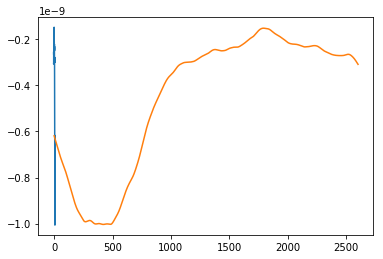

In [38]:
dat=baseline_als(a[1],1000,0.01,500)
plt.plot(a[0],a[1])
plt.plot(dat)
expt=a[1]-dat


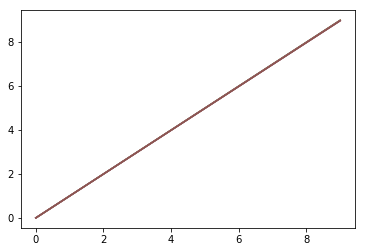

In [39]:
plt.plot(exp1[0],exp1[1])
plt.plot(exp1[0],exp1[2])
plt.plot(exp1[0],exp1[3])
plt.plot(exp1[0],exp1[4])
plt.plot(exp1[0],exp1[5])
plt.plot(exp1[0],exp1[6])


In [40]:
a[1].shape

(2604L,)

In [42]:
if __name__=="__main__":
    import numpy as np
    import pylab as mpl

    wavelet=Morlet
    maxscale=4
    notes=100
    scaling="log" #or "linear"
    #scaling="linear"
    plotpower2d=True

    # set up some data
    Ns=1024
    #limits of analysis
    Nlo=0 
    Nhi=Ns
    
    # Wavelet transform the data
    cw=wavelet(a[1]-dat,maxscale,notes,scaling=scaling)
    scales=cw.getscales()     
    cwt=cw.getdata()
    # power spectrum
    pwr=cw.getpower()
    scalespec=np.sum(pwr,axis=1)/scales # calculate scale spectrum
    # scales
    y=cw.fourierwl*scales
    x=np.arange(Nlo*1.0,Nhi*1.0,1.0)
    #x=np.arange(0,0.7,0.01)
    fig=mpl.figure(1)

    # 2-d coefficient plot
    ax=mpl.axes([0.4,0.1,0.55,0.4])
    mpl.xlabel('$V_L$ (mV)')
    plotcwt=np.clip(np.fabs(cwt.real), 0., 1000.)
    if plotpower2d: plotcwt=pwr
    im=mpl.imshow(plotcwt,cmap=mpl.cm.jet,extent=[-1,0,y[-1],y[0]],aspect='auto')
    #plt.colorbar()
    if scaling=="log": ax.set_yscale('log')
    mpl.ylim(y[0],y[-1])
    #mpl.xlim(0.5,-2)
    #ax.xaxis.set_ticks(np.arange(Nlo*1.0,(Nhi+1)*1.0,100.0))
    ax.yaxis.set_ticklabels(["",""])
    theposition=mpl.gca().get_position()

    # data plot
    ax2=mpl.axes([0.4,0.54,0.55,0.3])
    mpl.ylabel('I (nA)')
    pos=ax.get_position()
    mpl.plot(a[1]*1E9,'b-')
    #mpl.xlim(Nlo*1.0,Nhi*1.0)
    #mpl.ylim(0,4)
    ax2.xaxis.set_ticklabels(["",""])
    #mpl.text(0.5,0.9,"Wavelet transform",
      #   fontsize=14,bbox=dict(facecolor='green',alpha=0.2),
      #   transform = fig.transFigure,horizontalalignment='center')

    # projected power spectrum
    ax3=mpl.axes([0.08,0.1,0.29,0.4])
    mpl.xlabel('Power')
    mpl.ylabel('Period (mV)')
    vara=1.0
    if scaling=="log":
        mpl.loglog(scalespec/vara,y*0.0025,'b-')
    else:
        mpl.semilogx(scalespec/vara,y*0.0025,'b-')
    mpl.ylim(y[0]*0.0025,y[-1]*0.0025)
    #mpl.xlim((x[0],x[-1])
    #plt.savefig('D:\galya4', format='pdf')
    mpl.show()

TypeError: range() integer end argument expected, got float.

In [1]:
im=mpl.imshow(plotcwt*1E21,cmap=mpl.cm.jet,vmin=0.1,vmax=4,extent=[-1,0,y[-1],y[0]],aspect='auto')
mpl.xlim(-0.6,0)
mpl.ylim(200,400)

NameError: name 'mpl' is not defined

In [2]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(a[0]*87.5,-a[1]*1E9,'b-')
ax.set_xlim(-350,350)
ax.set_ylim(0.125,0.35)
plt.xlabel("$B$ (mT)", color='k',fontsize=12)
plt.ylabel("$I$ (nA)", color='k',fontsize=12)
plt.tick_params(direction='in')
plt.yticks([0.15,0.2,0.25,0.3,0.35],fontsize=10)
ax2 = ax.twinx()
plt.plot(a[0]*87.5,plotcwt[250]*1E21,'r-')
plt.xlabel("$B$ (mT)", color='k',fontsize=12)
plt.ylabel("$\\nu\,\,(\%)$", color='k',fontsize=12)
b=3
c=0.8E-1
plt.ylim(0)
x=np.linspace(-100, 100, num=1000)
#plt.plot(a[0], 0.076*np.exp(-b/mag(c*a[0])), 'r-', label='fit')
def mag(x):
    return (np.exp(x)-np.exp(-x))/(2*x)
plt.plot(x, 0.5*np.exp(-b/mag(c*x)), 'k-',linewidth=3,alpha=0.6, label='fit_cont')

plt.tick_params(direction='in')
ax2.set_xlim(-350,350)
aa = plt.axes([.42, .55, .2, .25], facecolor='w')
plt.ylabel("$\\nu\,\,(\%)$", color='k',fontsize=12)
plt.xlabel("$1/B$ (mT$^{-1}$)", color='k',fontsize=12)
plt.plot(1/(a[0]*87.5),plotcwt[250]*1E21,'r-')
plt.xlim(0,0.03)
plt.ylim(0.01,2.3)
plt.savefig('D:\\test1.pdf',bbox_inches='tight', format='pdf',dpi=900)
#plt.savefig('D:\\test2.pdf',bbox_inches='tight', format='pdf',dpi=900)
plt.show()


NameError: name 'plt' is not defined

In [3]:
import scipy.fftpack
plt.plot(1/(a[0]*87.5),plotcwt[250]*1E21,'r-')
plt.xlim(0,0.03)
plt.ylim(0.01,2.3)
#yf = scipy.fftpack.fft(plotcwt[250]*1E21)
plt.plot(yf)
#plt.xlim(0,100)
#plt.savefig('D:\\test2.pdf',bbox_inches='tight', format='pdf',dpi=900)

NameError: name 'plt' is not defined

In [4]:
import numpy as np
import matplotlib.pyplot as plt
def mag(x):
    return (np.exp(x)-np.exp(-x))/(2*x)
from scipy.optimize import curve_fit
xdata=a[0,1700:1925]*87.5
ydata=plotcwt[250,1700:1925]*1E21
def func(x, a, b):
    return a*np.exp(-b*mag(1E-3*x))
popt, pcov = curve_fit(func, xdata, ydata,bounds=(1, [2, 1E-10]))
plt.plot(xdata, func(xdata, *popt), 'r-', label='fit')
plt.plot(xdata,ydata, 'ok')
#plt.yscale('log')
plt.show()

NameError: name 'a' is not defined

In [ ]:
plt.plot(1/a[0]*1000,a[1]*1E9)
plt.xlim(200,900)
plt.ylim(-0.4,-0.2)

In [ ]:
plotcwt.shape

In [ ]:
# R package names
packnames = ('ggplot2', 'hexbin', '/home/sergey/R/x86_64-pc-linux-gnu-library/3.1/wmtsa')

# import rpy2's package module
import rpy2.robjects.packages as rpackages

if all(rpackages.isinstalled(x) for x in packnames):
    have_tutorial_packages = True
else:
    have_tutorial_packages = False

In [ ]:
from rpy2.robjects.packages import importr
#utils = importr('utils')
#utils.install_packages('wmtsa')

In [ ]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

In [ ]:
rwavCWT = importr('wmtsa')
rwavCWT = robjects.r['wavCWT']
rwavCWTTree = robjects.r['wavCWTTree']
rholderSpectrum=robjects.r['holderSpectrum']
p=100
rexpt = robjects.FloatVector((1E9*expt))
W=rwavCWT(rexpt,wavelet="Morlet",variance=1/p) #


In [ ]:
rexpt

In [ ]:
import numpy as np
import rpy2.robjects as robjects
Wnp=np.array(list(W)).reshape(W.dim)


In [ ]:
plt.imshow(Wnp.real*Wnp.real,cmap=mpl.cm.jet,extent=[0.5,-2,y[-1],y[0]],aspect='auto')
#mpl.ylim(y[0],y[-1])

In [ ]:
W

In [ ]:
Wtree=rwavCWTTree(W) # 1/2
Res=rholderSpectrum(Wtree) # 1/4

In [ ]:
Res

In [ ]:
Res

In [ ]:
m = robjects.r['matrix'](Res, nrow = 2)

In [ ]:
v1 = np.array(m[0])
v2 = np.array(m[1])
v3 = np.array(m[2])


In [ ]:
v3

In [ ]:

plt.plot(v2,v1, 'o')

plt.plot(expt*1E9)